In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import timedelta
from statsmodels.tsa.arima_model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from scipy.ndimage.filters import gaussian_filter
import matplotlib.dates as mdates
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import os
import warnings


warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

In [128]:
def arima_model(series, data_split, params, future_periods, log):
    
    # log transformation of data if user selects log as true
    if log == True:
        series_dates = series.index
        series = pd.Series(np.log(series), index=series.index)
       
    # create training and testing data sets based on user split fraction
    size = int(len(series) * data_split)
    train, test = series[0:size], series[size:len(series)]
    history = [val for val in train]
    predictions = []

    # creates a rolling forecast by testing one value from the test set, and then add that test value
    # to the model training, followed by testing the next test value in the series
    for t in range(len(test)):
        model = ARIMA(history, order=(params[0], params[1], params[2]))
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat[0])
        obs = test[t]
        history.append(obs)
    
    # forecasts future periods past the input testing series based on user input
    future_forecast = model_fit.forecast(future_periods)[0]
    future_dates = [test.index[-1]+timedelta(i*365/12) for i in range(1, future_periods+1)]
    test_dates = test.index
    
    # if the data was originally log transformed, the inverse transformation is performed
    if log == True:
        predictions = np.exp(predictions)
        test = pd.Series(np.exp(test), index=test_dates)
        future_forecast = np.exp(future_forecast)
    
    # creates pandas series with datetime index for the predictions and forecast values
    forecast = pd.Series(future_forecast, index=future_dates)
    predictions = pd.Series(predictions, index=test_dates)
    
    # generates plots to compare the predictions for out-of-sample data to the actual test values
    fig = plt.figure()
    ax = fig.add_subplot(111)
    #myFmt = mdates.DateFormatter('%m%/%y')
    #ax.xaxis.set_major_formatter(myFmt)
    plt.plot(predictions, c='red')
    plt.plot(test)
    plt.show()
    
    # calculates root mean squared errors (RMSEs) for the out-of-sample predictions
    error = np.sqrt(mean_squared_error(predictions, test))
    print('Test RMSE: %.3f' % error)
    
    return predictions, test, future_forecast

In [129]:
def gauss_compare(original_series, predictions, data_split):
    
    # the train/test split used to generate the Gaussian-filtered predictions
    size = int(len(original_series)*data_split)

    # creating a plot of the original series and Gaussian-filtered predictions
    fig = plt.figure()
    ax = fig.add_subplot(111)
    #myFmt = mdates.DateFormatter('%m%/%y')
    #ax.xaxis.set_major_formatter(myFmt)

    plt.plot(original_series[size:])
    plt.plot(predictions, color='red')
    plt.title('Gauss-Filtered Predictions vs. Original Series')
    plt.show()
    
    # calculating the RMSE between the Gaussian-filtered predictions and original dataset. 
    # the +1 exception code is required when differencing is performed, as the earliest data point can be lost
    try:
        error = np.sqrt(mean_squared_error(predictions, original_series[size:]))
    except:
        error = np.sqrt(mean_squared_error(predictions, original_series[size+1:]))
    print('Test RMSE: %.3f' % error)

In [130]:
def evaluate_arima_model(X, arima_order, data_split):
    
    size = int(len(X) * data_split)
    train, test = series[0:size], series[size:len(series)]
    history = [val for val in train]
    predictions = list()
    
    print(size)

    # creates a rolling forecast by testing one value from the test set, and then add that test value
    # to the model training, followed by testing the next test value in the series
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat[0])        
        history.append(test[t])
    
    error = np.sqrt(mean_squared_error(test, predictions))
    return error

In [131]:
def find_best_parameter(series, order, data_split, log):
   
    
    # log transformation of data if user selects log as true
    if log == True:
        
        series_dates = series.index
        
        series = pd.Series(np.log(series), index=series.index)
        
    # create training and testing data sets based on user split fraction
    size = int(len(series) * data_split)
    
    train, test = series[0:size], series[size:len(series)]
    history = [val for val in train]
    predictions = []
    
    # creates a rolling forecast by testing one value from the test set, and then add that test value
    # to the model training, followed by testing the next test value in the series
    for t in range(len(test)):
                
        model = ARIMA(history, order=order)
                
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat[0])
        obs = test[t]
        history.append(obs)
    
    # forecasts future periods past the input testing series based on user input
    future_forecast = model_fit.forecast(future_periods)[0]
    future_dates = [test.index[-1]+timedelta(i*365/12) for i in range(1, future_periods+1)]
    test_dates = test.index
    
    # if the data was originally log transformed, the inverse transformation is performed
    if log == True:
        predictions = np.exp(predictions)
        test = pd.Series(np.exp(test), index=test_dates)
        future_forecast = np.exp(future_forecast)
    
    # creates pandas series with datetime index for the predictions and forecast values
    forecast = pd.Series(future_forecast, index=future_dates)
    predictions = pd.Series(predictions, index=test_dates)
    
    # generates plots to compare the predictions for out-of-sample data to the actual test values
    fig = plt.figure()
    ax = fig.add_subplot(111)
    #myFmt = mdates.DateFormatter('%m%/%y')
    #ax.xaxis.set_major_formatter(myFmt)
    plt.plot(predictions, c='red')
    plt.plot(test)
    plt.show()
    
    # calculates root mean squared errors (RMSEs) for the out-of-sample predictions
    error = np.sqrt(mean_squared_error(predictions, test))
        
    return error

In [143]:
def evaluate_models(dataset, p_values, d_values, q_values, data_split, log):
    dataset = dataset.astype('float32')
    
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                
                try:
                    mse = find_best_parameter(dataset, order, data_split, log)
                    
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s RMSE=%.3f' % (order,mse))
                
                except:                    
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [133]:
virus_trends = pd.Series(pd.read_excel("./data_set/virus_google_trend.xlsx",                                      
                                     parse_dates=['Month'],
                                     index_col = "Month").iloc[:,0]).astype(float)


In [134]:
virus_trends.head()

Month
2004-01-04     73.0
2004-02-04     72.0
2004-03-04     71.0
2004-04-04     67.0
2004-05-04    100.0
Name: virus: (Worldwide), dtype: float64

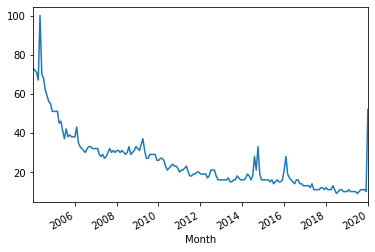

In [135]:
virus_trends.plot()

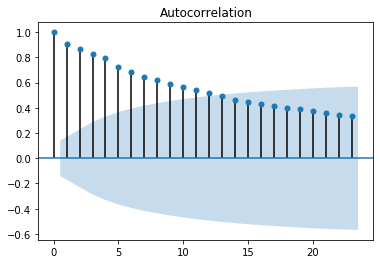

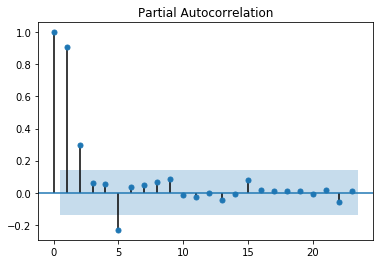

In [136]:
# acf, pacf

plot_acf(virus_trends)
plot_pacf(virus_trends)
plt.show()

< Log acf, pacf >


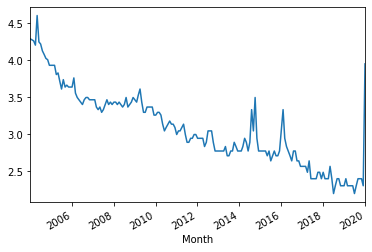

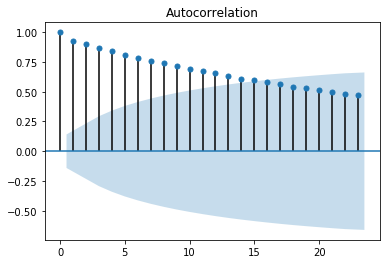

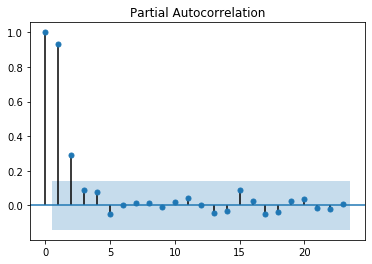

< 1-diff Log acf, pacf >


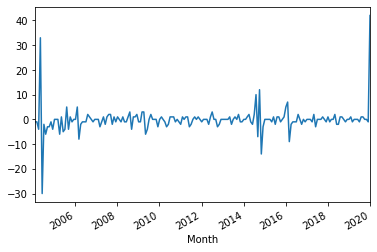

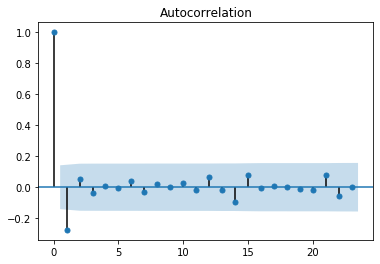

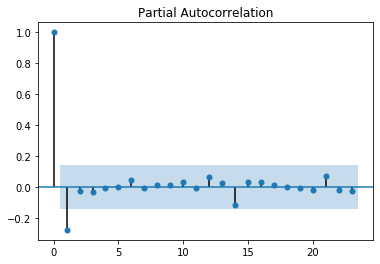

In [137]:
# log acf, log pacf
print("< Log acf, pacf >")
np.log(virus_trends).plot()
plot_acf(np.log(virus_trends))
plot_pacf(np.log(virus_trends))
plt.show()

# 1-diff acf, 1 diff pacf
print("< 1-diff Log acf, pacf >")
diff_1= virus_trends.diff(periods=1).iloc[1:]
diff_1.plot()
plot_acf(diff_1)
plot_pacf(diff_1)
plt.show()

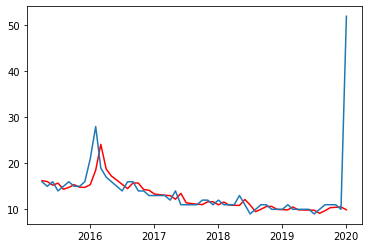

Test RMSE: 5.835


In [138]:
# running ARIMA model

data_split = 0.7
p = 1
d = 1
q = 1
params = [p, d, q]
future_periods = 12
log = True

predictions, test, forecast = arima_model(virus_trends, data_split, params, future_periods, log)

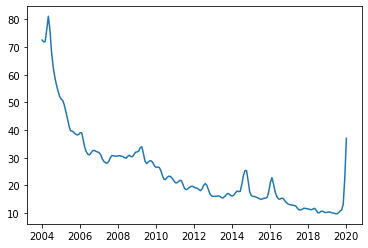

In [139]:
# Gauus filter 
virus_gauss = pd.Series(gaussian_filter(virus_trends, sigma=1), index=virus_trends.index).astype(float)
plt.plot(virus_gauss)
plt.show()

< 1-diff gauss acf, pacf >


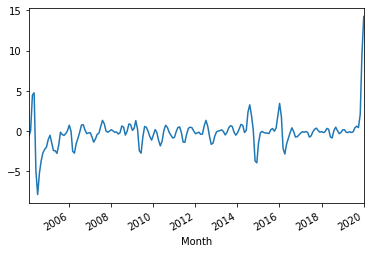

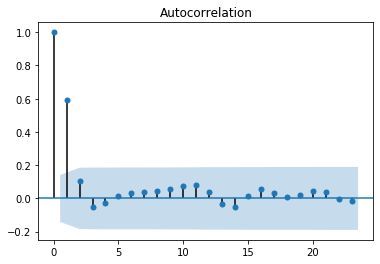

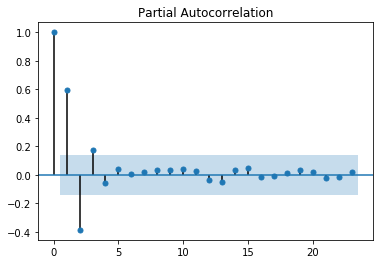

In [140]:
# 1-diff acf, 1 diff pacf
print("< 1-diff gauss acf, pacf >")
diff_1= virus_gauss.diff(periods=1).iloc[1:]
diff_1.plot()
plot_acf(diff_1)
plot_pacf(diff_1)
plt.show()

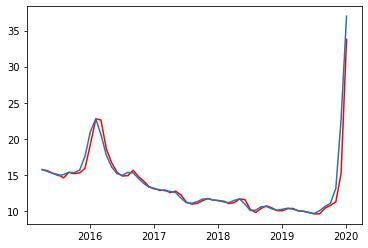

Test RMSE: 1.203


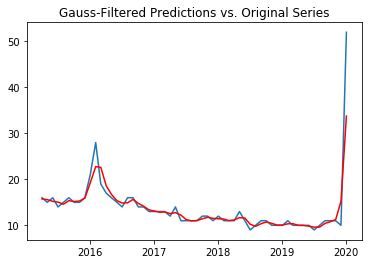

Test RMSE: 2.699


In [147]:
# running ARIMA model with Gaussian Filter
data_split = 0.7
p = 0
d = 1
q = 1
params = [p, d, q]
future_periods = 12
log = True

predictions, test, forecast = arima_model(virus_gauss, data_split, params, future_periods, log)

# comparing ARIMA model with Gaussin filter to original series
gauss_compare(virus_trends, predictions, data_split)

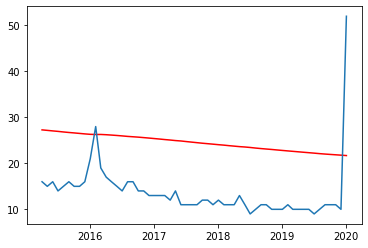

ARIMA(0, 0, 0) RMSE=12.398


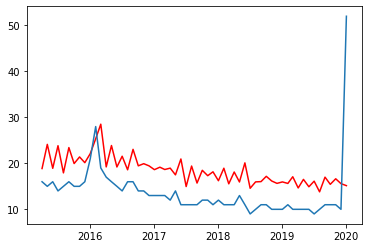

ARIMA(0, 0, 1) RMSE=7.678


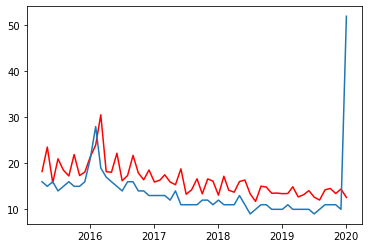

ARIMA(0, 0, 2) RMSE=6.670


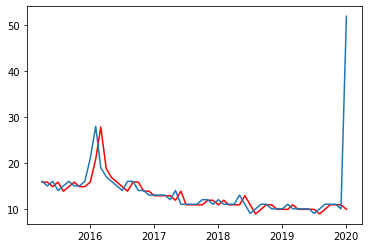

ARIMA(0, 1, 0) RMSE=5.860


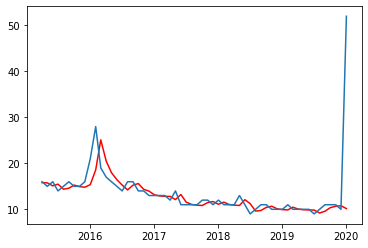

ARIMA(0, 1, 1) RMSE=5.836


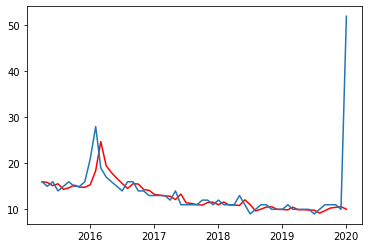

ARIMA(0, 1, 2) RMSE=5.840


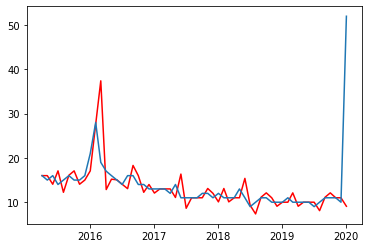

ARIMA(0, 2, 0) RMSE=6.389


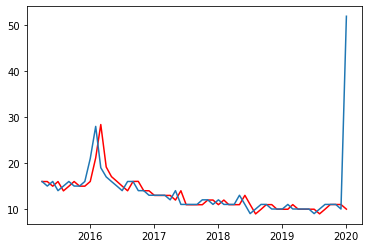

ARIMA(0, 2, 1) RMSE=5.863


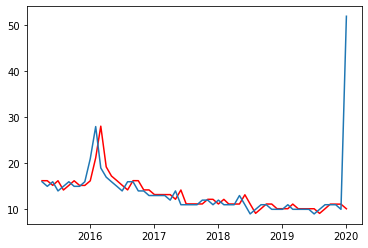

ARIMA(1, 0, 0) RMSE=5.839


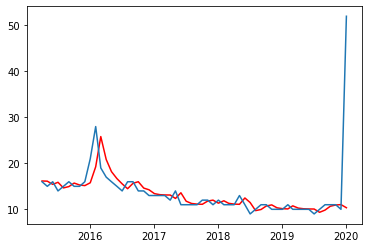

ARIMA(1, 0, 1) RMSE=5.814


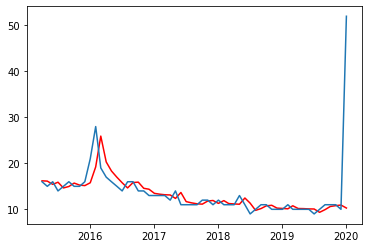

ARIMA(1, 0, 2) RMSE=5.820


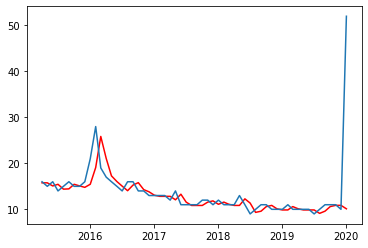

ARIMA(1, 1, 0) RMSE=5.848


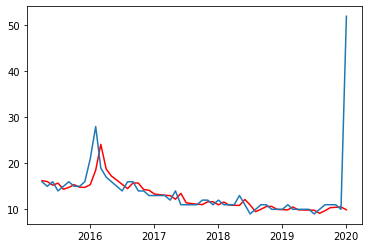

ARIMA(1, 1, 1) RMSE=5.835


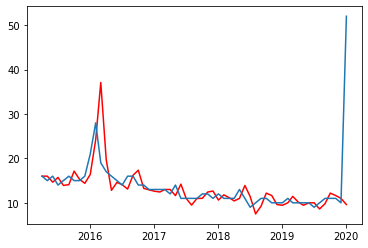

ARIMA(1, 2, 0) RMSE=6.277


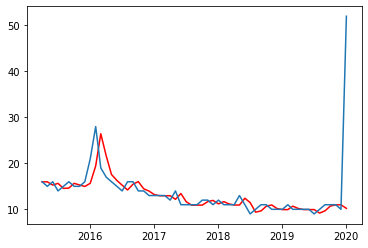

ARIMA(1, 2, 1) RMSE=5.848


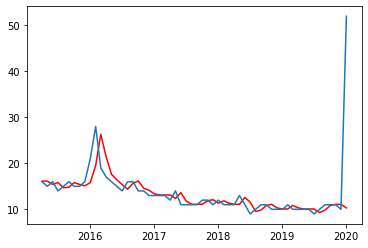

ARIMA(2, 0, 0) RMSE=5.828


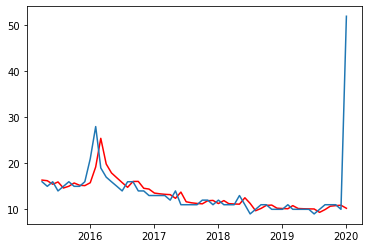

ARIMA(2, 0, 1) RMSE=5.812


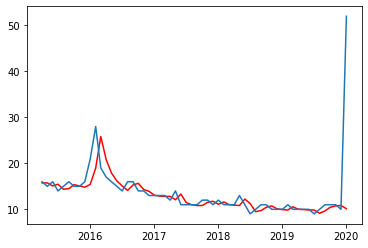

ARIMA(2, 1, 0) RMSE=5.847


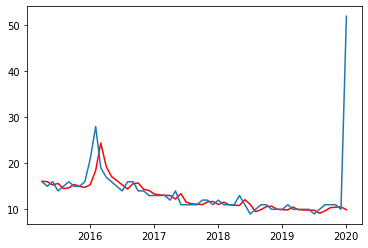

ARIMA(2, 1, 1) RMSE=5.841


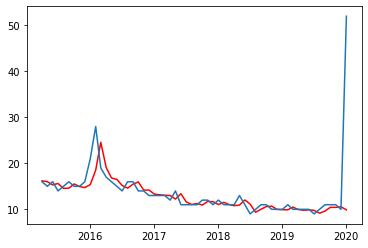

ARIMA(2, 1, 2) RMSE=5.845


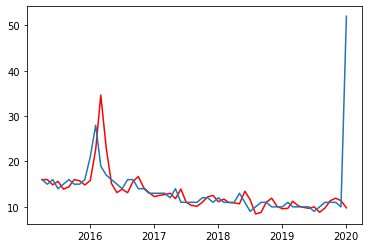

ARIMA(2, 2, 0) RMSE=6.171


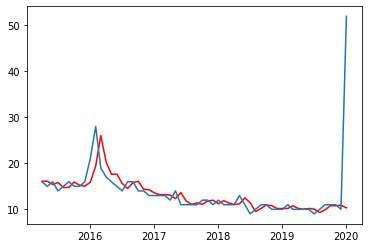

ARIMA(4, 0, 0) RMSE=5.815


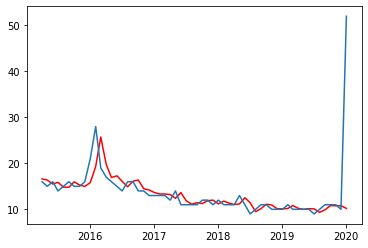

ARIMA(4, 0, 1) RMSE=5.821


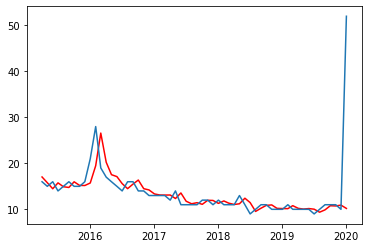

ARIMA(4, 0, 2) RMSE=5.840


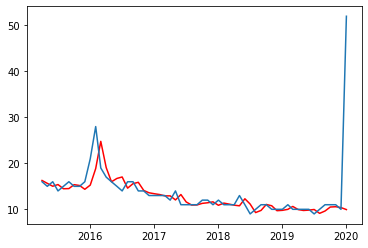

ARIMA(4, 1, 0) RMSE=5.846


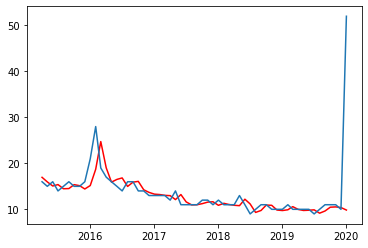

ARIMA(4, 1, 1) RMSE=5.861


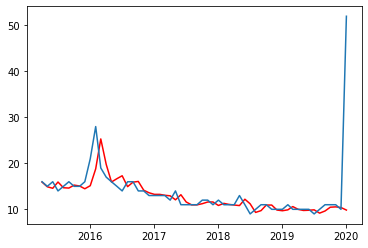

ARIMA(4, 1, 2) RMSE=5.881


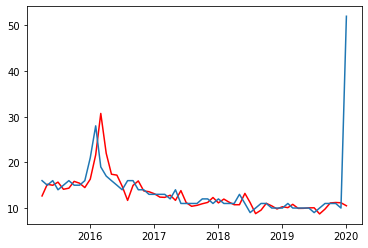

ARIMA(4, 2, 0) RMSE=5.940


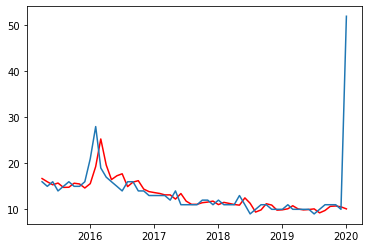

ARIMA(4, 2, 1) RMSE=5.838
Best ARIMA(2, 0, 1) RMSE=5.812


In [144]:
# find best p, d, q parameter

p_values = [0, 1, 2, 4 ]
d_values = range(0, 3)
q_values = range(0, 3)

evaluate_models(virus_trends, p_values, d_values, q_values, data_split, log)

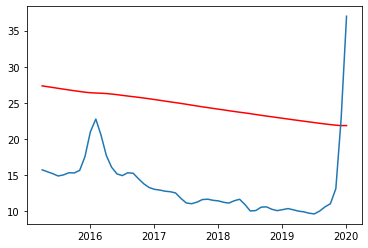

ARIMA(0, 0, 0) RMSE=11.766


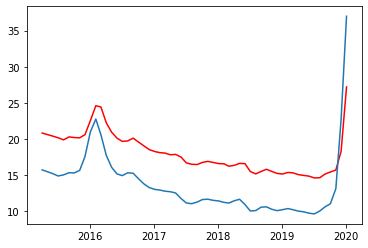

ARIMA(0, 0, 1) RMSE=5.022


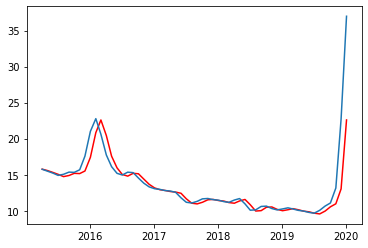

ARIMA(0, 1, 0) RMSE=2.444


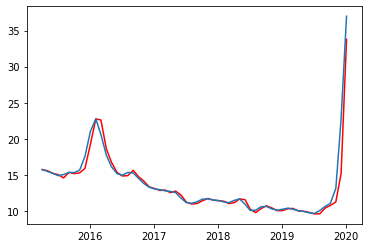

ARIMA(0, 1, 1) RMSE=1.203


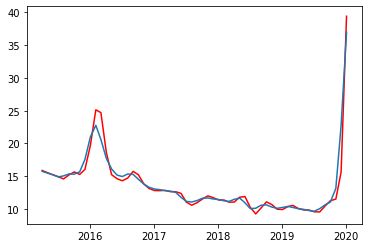

ARIMA(0, 2, 0) RMSE=1.268


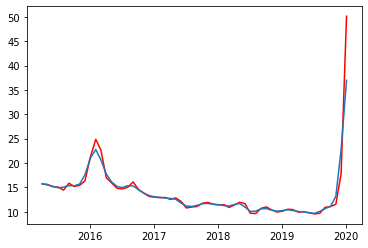

ARIMA(0, 2, 1) RMSE=1.924


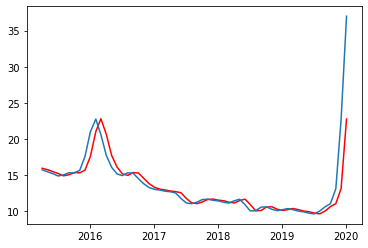

ARIMA(1, 0, 0) RMSE=2.418


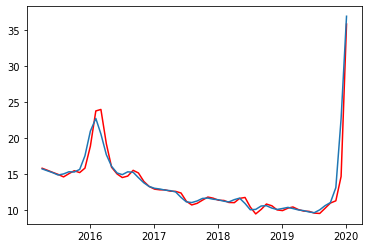

ARIMA(1, 1, 0) RMSE=1.287


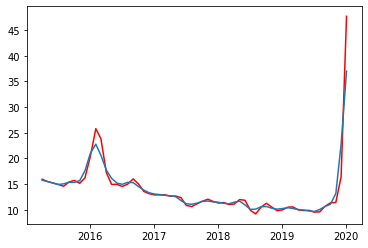

ARIMA(1, 2, 0) RMSE=1.792


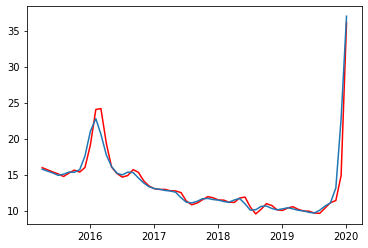

ARIMA(2, 0, 0) RMSE=1.272


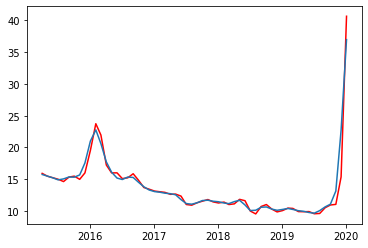

ARIMA(2, 1, 0) RMSE=1.202


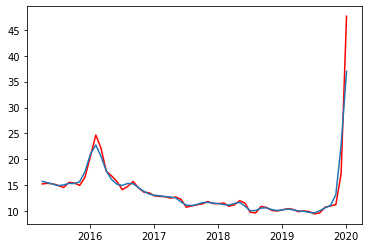

ARIMA(2, 2, 0) RMSE=1.663


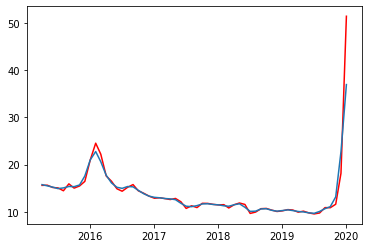

ARIMA(2, 2, 1) RMSE=2.052


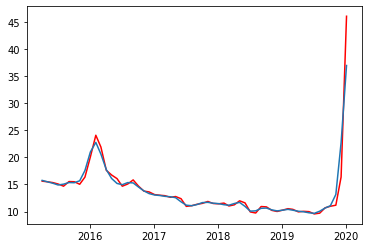

ARIMA(4, 0, 0) RMSE=1.538


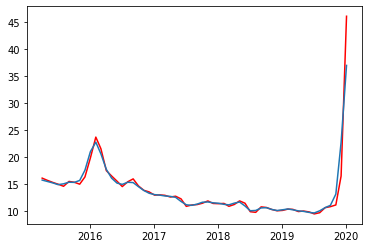

ARIMA(4, 1, 0) RMSE=1.519


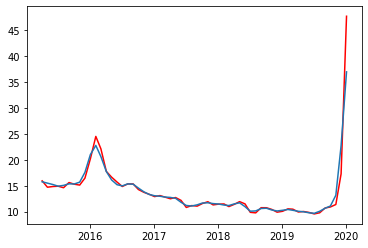

ARIMA(4, 2, 0) RMSE=1.656


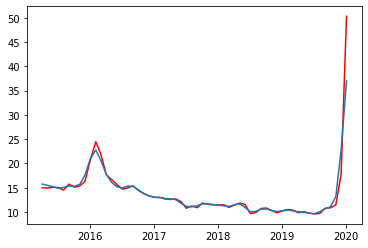

ARIMA(4, 2, 1) RMSE=1.929


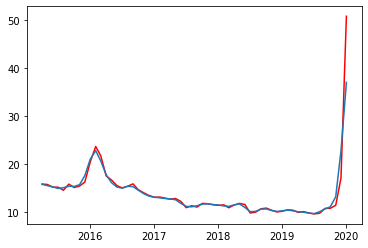

ARIMA(4, 2, 2) RMSE=2.002
Best ARIMA(2, 1, 0) RMSE=1.202


In [145]:
# find best p, d, q parameter

p_values = [0, 1, 2, 4 ]
d_values = range(0, 3)
q_values = range(0, 3)

evaluate_models(virus_gauss, p_values, d_values, q_values, data_split, log)